# 설정

In [86]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Voting"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

무작위로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모은다고 가정하자. 많은 경우 이렇게 모은 답이 전문가의 답보다 낫다. 이를 <b>대중의 지혜</b><sup>wisdom of the crowd</sup>라고 한다. 이와 비슷하게 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것이다. 일련의 예측기를 <b>앙상블</b>이라고 부르기 때문에 이를 <b>앙상블 학습</b><sup>ensemble learning</sup>이라고 하며, 앙상블 학습 알고리즘을 <b>앙상블 방법</b><sup>ensemble method</sup>이라고 한다. 앙상블 학습의 목표는 다양한 분류기의 예측 결과를 결합함으로써 단일 분류기보다 신뢰성이 높은 예측값을 얻는 것이다. 다음은 앙상블의 특징이다.

<ul>
    <li>단일 모델의 약점을 다수의 모델들을 결합하여 보완</li>
    <li>뛰어난 성능을 가진 모델들로만 구성하는 것보다 성능이 떨어지더라도 서로 다른 유형의 모델을 섞는 것이 오히려 전체 성능에 도움이 될 수 있음</li>
    <li>랜덤 포레스트 및 뛰어난 부스팅 알고리즘들은 모두 결정트리 알고리즘을 기반으로 적용함</li>
    <li>결정트리의 단점인 과대적합(오버피팅)을 수십~수천 개의 많은 분류기를 결합해 보완하고 장점인 직관적인 분류 기준을 강화</li>
</ul>

앙상블 방법의 예를 들면 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있다. 예측을 하려면 모든 개별 트리의 예측을 구하면 된다. 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼는다. 결정 트리의 앙상블을 <b>랜덤 포레스트</b><sup>random forest</sup>라고 한다. 간단한 방법임에도 랜덤 포레스트는 오늘날 가장 강력한 머신러닝 알고리즘 중 하나다.

프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 이미 만든 여러 괜찮은 예측기를 연결하여 더 좋은 예측기를 만든다. 사실 머신러닝 경연 대회에서 우승하는 솔루션은 여러 가지 앙상블 방법을 사용한 경우가 많다. 이는 특히 넷플릭스 대회에서 가장 인기 있다.

# 투표 기반 분류기

정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정하자. 아마도 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등을 가지고 있을 수 있다(그림 1).

<b>그림 1</b> 여러 분류기 훈련시키기
<div style="text-align:center;">
    <img src="./images/Ensemble/여러 분류기 훈련시키기.png">
</div>

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이렇게 다수결 투표로 정해지는 분류기를 <b>직접 투표</b><sup>hard voting</sup> 분류기라고 한다(그림 2).

<b>그림 2</b> 직접 투표 분류기의 예측
<div style="text-align:center;">
    <img src="./images/Ensemble/직접 투표 분류기의 예측.png">
</div>

조금 놀랍게도 이 다수결 튜표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많다. 사실 각 분류기가 <b>약한 학습기</b><sup>weak learner</sup>(즉, 랜덤 추축보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는)<b>강한 학습기</b><sup>strong learner</sup>가 될 수 있다.

과반수 투표나 다수결 투표로 클래스 레이블을 예측하려면 개별 분류기 $C_j$의 예측 레이블을 모아 가장 많은 표를 받은 레이블 $\hat{y}$를 선택한다.

$$
\hat{y} = mode\left\{C_1(\mathrm{x}), C_2(\mathrm{x}), ..., C_m(\mathrm{x})\right\}
$$

예를 들어 class1 = -1이고 class2 = +1인 이진 분류 작업에서 과반수 투표 예측은 다음과 같이 쓸 수 있다.

$$
C(\mathrm{x}) = sign[\sum_{j}^mC_j(\mathrm{x})] = \begin{cases}
1 & \text{ if } \sum_iC_j(\mathrm{x})\geq 0 \\
-1 & \text{ else} 
\end{cases}
$$

앙상블 방법이 개별 분류기보다 성능이 뛰어난 이유를 설명하기 위해 간단한 조합 이론을 적용해보겠다. 다음 예에서 이진 분류 작업에 대해 동일한 에러율<sup>error rate</sup> $\varepsilon$를 가진 n개의 분류기를 가정해보자. 또 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정한다. 이런 가정하에 이 분류기의 앙상블이 만드는 오차 확률을 이항 분포<sup>binomial distribution</sup>의 확률 질량 함수<sup>probability mass function</sup>로 표현할 수 있다.

$$
    P(y\geq k) = \sum_k^n\varepsilon^k\binom{n}{k}(1 - \varepsilon)^{n-k} = \varepsilon_{ensemble}
$$

여기서 $\binom{n}{k}$는 이항 계수<sup>binomial coefficient</sup>로 $n$개 원소에서 $k$개를 뽑는 조합의 가짓수다. 이 식은 앙상블의 예측이 틀릴 확률을 계산한다. 좀 더 구체적으로 에러율이 0.25($\varepsilon=0.25$)인 분류기 11개($n = 11$)로 구성된 앙상블의 에러율은 다음과 같다.<sup><a id="a01" href="#p01">[1]</a></sup>

$$
P(y\geq k) = \sum_{k=6}^{11}\binom{n}{k}0.25^k(1-0.25)^{11-k} = 0.034
$$

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>이항 계수</b><br><br>
    이항 계수는 크기가 $n$인 집합에서 순서를 고려하지 않고 $k$개의 부분 집합을 선택할 수 있는 방법을 나타낸다. 종종 'n choose k'라고 읽는다. 순서에 상관하지 않기 때문에 이항 계수는 조합 또는 조합의 가짓수라고 말하기도 한다. 수식으로 표현하면 다음과 같다.
    $$
    \binom{n}{k} = \frac{n!}{(n-k)!k!}
    $$
    여기서 ! 기호는 팩토리얼<sup>factorial</sup>을 나타낸다. 예를 들어 3!=3x2x1=6이다.
</div>

앞서 보았듯이 모든 가정을 만족한다면 앙상블의 에러율(0.034)은 개별 분류기의 에러율(0.25)보다 훨씬 낮다. 만약 에러율이 0.5인 분류기가 짝수 개일 때 예측이 반반으로 나뉘면 에러로 취급된다. 이상적인 앙상블 분류기와 다양한 범위의 분류기를 가진 경우와 비교하기 위해 파이썬으로 확률 질량 함수를 구현해 보겠다.<sup><a id="a02" href="#p02">[2]</a></sup>

In [3]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

<code>ensemble_error()</code> 함수를 구현한 후에 분류기 에러가 0.0에서 1.0까지 걸쳐 있을 때 앙상블의 에러율을 계산하겠다. 그다음 앙상블과 개별 분류기 에러 사이의 관계를 선 그래프로 시각화해보자.

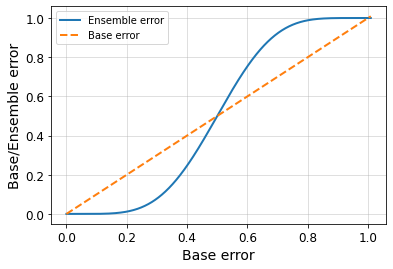

In [4]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.001)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

결과 그래프에서 볼 수 있듯이 앙상블의 에러 확률은 개별 분류기보다 항상 좋다. 다만 개별 분류기가 무작위 추측($\varepsilon < 0.5$)보다 성능이 좋아야 한다. y축은 분류기 에러(점선)과 앙상블 에러(실선)를 나타낸다.

<b>TIP</b> 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.

## 간단한 다수결 투표 분류기 표현

이 절에서 구현할 알고리즘은 여러 가지 분류 모델의 신뢰도에 가중치를 부여하여 연결할 수 있다. 여기서는 특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축하는 것이 목표다. 수학적으로 표현하면 가중치가 적용된 다수결 투표는 다음과 같이 쓸 수 있다.

$$
\hat{y} = \underset{i}{\text{argmax}}\sum_{j=1}^m\mathrm{w}_j\chi_A(C_j(\mathrm{x}) = i)
$$

여기서 $\mathrm{w}_j$는 개별 분류기 $C_j$에 연관된 가중치다. $\hat{y}$는 앙상블이 예측한 클래스 레이블이다. $\chi_A$(그리스어로 카이<sup>chi</sup>)는 특성 함수<sup>characteristic function</sup> $[C_j(\mathrm{x}) = i \in A]$이다. A는 고유한 클레스 레이블 집합이다. 가중치가 동일하면 이 식을 다음과 같이 간단히 쓸 수 있다.

$$
\hat{y} = mode\left\{C_1(\mathrm{x}), C_2(\mathrm{x}), ..., C_m({\mathrm{x}})\right\}
$$

가중치 개념을 더욱 잘 이해하기 위해 좀 더 구체적인 예제를 살펴보겠다. 세 개의 분류기 $C_j(j\in\left\{0, 1, 2\right\})$가 있고 샘플 x의 클래스 레이블을 예측해야 한다고 가정하자. 세 개의 분류기 중 두 개가 클래스 0을 예측하고 $C_3$ 하나가 샘플을 클래스 1로 예측했다. 분류기 세 개의 예측 가중치가 동일하다면 다수결 투표는 이 샘플이 클래스 0에 속한다고 예측할 것이다.

$$
C_1(\mathrm{x})\to0,\,C_2(\mathrm{x})\to0,\,C_3(\mathrm{x})\to1\\
\hat{y} = mode\left\{0, 0, 1\right\} = 0
$$

이제 $C_3$에 가중치 0.6을 할당하고 $C_1$과 $C_2$에 0.2를 부여해 보겠다.<sup><a id="a03" href="#p03">[3]</a></sup>

$$
\begin{align*}
\hat{y} &= \underset{i}{\mathrm{argmax}}\sum_{j=1}^{m}\mathrm{w}_j\chi_A(C_j(\mathrm{x}) = i)\\
 &= \underset{i}{\mathrm{argmax}}[0.2\times i_0 + 0.2 \times i_0 + 0.6 \times i_1] = 1
\end{align*}
$$

직관적으로 생각했을 때 3 x 0.2 = 0.6이기 때문에 $C_3$의 예측이 $C_1$이나 $C_2$의 예측보다 3배 더 가중된다. 즉, 다음과 같이 쓸 수 있다.

$$
\hat{y} = mode\left\{0, 0, 1, 1, 1\right\} = 1
$$

<code>argmax()</code>와 <code>bincount()</code> 함수<sup><a id="a04" href="#p04">[4]</a></sup>를 사용하여 가중치가 적용된 다수결 투표를 파이썬 코드로 구현할 수 있다.

In [5]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
          weights=[0.2, 0.2, 0.6]))

1

사이킷런의 일부 분류기는 <code>predict_proba()</code> 메서드에서 예측 클래스 레이블의 확률을 반환할 수 있다. 앙상블의 분류기가 잘 보정<sup>calibration</sup><sup><a id="a05" href="#p05">[5]</a></sup>되어 있다면 다수결 투표에서 클래스 레이블 대신 예측 클래스 확률을 사용하는 것이 좋다. 확률을 사용하여 클래스 레이블을 에측하는 다수결 투표 버전은 다음과 같이 쓸 수 있다.

$$
\hat{y} = \underset{i}{\mathrm{argmax}}\sum_{j=1}^m\mathrm{w}_jp_{ij}
$$

여기서 $P_{ij}$는 클래스 레이블 $i$에 대한 $j$번째 분류기의 예측 확률이다.

앞선 예제에 이어서 클래스 레이블 $i \in \left\{0, 1\right\}$인 이진 분류 문제에서 세 개의 분류기로 구성된 앙상블 $C_j(j\in\left\{1, 2, 3\right\})$을 가정해 보자. 어떤 샘플 $\mathrm{x}$에 대한 분류기 $C_j$는 다음과 같은 클래스 소속 확률을 반환한다.

$$
C_1(\mathrm{x})\to[0.9, 0.1],\, C_2(\mathrm{x})\to[0.8, 0.2],\, C_3(\mathrm{x})\to[0.4, 0.6]
$$

그다음 각 클래스 확률을 다음과 같이 계산할 수 있다.

$$
p(i_0|\mathrm{x}) = 0.2 \times0.9+0.2\times0.8+0.6\times0.4 = 0.58\\
p(i_1|\mathrm{x}) = 0.2 \times0.1+0.2\times0.2+0.6\times0.6 = 0.42\\
\hat{y} = \underset{i}{\mathrm{argmax}}[p(i_0|\mathrm{x}),\,p(i_1|\mathrm{x})] = 0
$$

넘파이의 <code>average()</code><sup><a id="a06" href="#p06">[6]</a></sup>와 <code>argmax()</code> 함수를 사용하여 클래스 확률 기반으로 가중치가 적용된 다수결 투표를 구현할 수 있다.

In [7]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [8]:
np.argmax(p)

0

이들을 모두 결합하여 MajorityVoteClassifier 파이썬 클래스를 구현해 보자.

In [29]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from six import iteritems
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기
    
    매개변수
    ------------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
        
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 된다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측한다(보정된 분류기에 추천한다)
        
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치된다
        'weights=None'이면 동일하게 취급한다
        
    """
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in 
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """분류기를 학습한다
        
        매개변수
        -----------
        X : {배열 타입, 희소 행렬},
             크기 = [n_samples, n_features]
             훈련 샘플 행렬
             
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -----------
        self: 객체
        
        """
        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용한다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """X에 대한 클래스 레이블을 예측한다
        
        매개변수
        -----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
            
        반환값
        -----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else:# 'classlabel' 투표
            
            # clf.predict 메서드를 사용하여 결과를 모은다
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(
                            lambda x:
                            np.argmax(np.bincount(x, 
                                      weights=self.weights)),
                            axis=1,
                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측한다
        
        매개변수
        ------------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
            
        반환값
        -----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
            
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas,
                               axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환한다"""
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
        return out

사이킷런은 보팅 방식의 앙상블을 구현한 VotingClassifer 클래스를 제공하고 있다. 위에서 구현한 MajorityVoteClassifier의 vote 매개변수는 VotingClassifier의 voting 매개변수에 해당한다. voting 매개변수의 기본값은 다수결 투표를 기반으로 예측하는 'hard'이고, 확률을 기반으로 하는 'soft'도 있다.

## 다수결 투표 방식을 사용하여 예측 만들기

iris 데이터의 꽃받침 너비와 꽃잎 길이 두 개의 특성만 사용하여 예제를 구성해 보겠다. MajorityVoteClassifier 클래스를 다중 분류 문제에 적용할 수 있지만 나중에 ROC AUC를 계산하기 위해 Iris-versicolor와 Iris-virginica 클래스에 해당하는 샘플만 분류하겠다. 코드는 다음과 같다.

In [24]:
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 사이킷런은 ROC AUC를 계산하기 위해 (가능하면) predict_proba() 메서드를 사용한다. 결정 트리에서는 훈련할 때 각 노드에서 생성되는 빈도 벡터<sup>frequency vector</sup>로부터 확률을 계산한다. 이 벡터는 노드의 클래스 레이블 빈도 값으로 채워진다. 그다음 빈도 값의 합이 1이 되도록 정규화한다. 비슷하게 k-최근접 이웃 알고리즘에서도 클래스 레이블을 모아 정규화된 클래스 레이블의 빈도를 반환한다.<sup><a id="a07" href="#p07">[7]</a></sup> 결정 트리와 k-최근접 이웃 분류기에서 반환되는 정규화된 확률이 로지스틱 회귀 모델에서 얻은 확률과 비슷하게 보인다. 하지만 이들은 실제로 확률 질량 함수로부터 얻어진 것이 아님을 기억하자.<sup><a id="a08" href="#p08">[8]</a></sup>
</div>

그다음 붓꽃 데이터 샘플을 50%는 훈련 데이터로 나누고, 50%는 테스트 데이터로 나눈다.

In [18]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y,
                         test_size=0.5,
                         random_state=1,
                         stratify=y)

훈련 세트를 사용하여 서로 다른 세 개의 분류기를 훈련한다.
<ul>
    <li>로지스틱 회귀 분류기</li>
    <li>결정 트리 분류기</li>
    <li>k-최근접 이웃 분류기</li>
</ul>

각 분류기를 앙상블로 묶기 전에 훈련 세트에서 10-겹 교차 검증으로 성능을 평가해보자.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(solver='liblinear',
                          penalty='l2',
                          C=0.001,
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
               % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


위 출력 결과에서 볼 수 있듯이 각 분류기의 예측 성능은 거의 비슷하다.

로지스틱 회귀와 (유클리디안 거리를 사용하는) k-최근접 이웃 알고리즘은 결정 트리와는 달리 스케일에 민감해서 표준화 전처리를 진행했다. 붓꽃 데이터의 특성이 모두 같은 스케일(cm)로 측정되었지만 특성을 표준화 전처리하는 것은 좋은 습관이다.

이제 다수결 투표 앙상블을 위해 MajorityVoteClassifier 클래스로 각 분류기를 하나로 연결해보자.

In [30]:
mv_clf = MajorityVoteClassifier(
                 classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
              % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


결과에서 보듯이 10-겹 교차 검증으로 평가했을 때 MajorityVoteClassifer의 성능이 개별 분류기보다 뛰어나다.

## 앙상블 분류기의 평가와 튜닝

이 절에서는 본 적 없는 데이터에 대한 MajorityVoteClassifier의 일반화 성능을 확인하기 위해 ROC 곡선을 그려 보겠다. 테스트 세트는 모델 선택에 사용하지 않았다는 것을 기억하자. 테스트 세트의 목적은 편향되지 않은 분류기의 일반화 성능을 추정하기 위해서다.

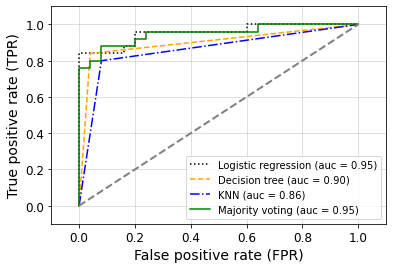

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 양성 클래스의 레이블이 1이라고 가정한다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

구해진 ROC 곡선에서 보듯이 앙상블 분류기는 테스트 세트에서도 좋은 성능을 낸다(ROC AUC=0.95). 로지스틱 회귀도 같은 데이터에서 비슷한 성능을 내고 있다. 이는 아마도 작은 데이터셋에서 생기는 높은 분산 때문이다(이 경우 데이터셋을 어떻게 나누었는지에 민감하다).

이 분류 문제에서는 두 개의 특성만 선택했기 때문에 앙상블의 결정 경계가 어떤 모습인지 확인해볼 수 있다. 사실 로지스틱 회귀와 k-최근접 이웃 파이프라인에 이미 전처리 단계가 포함되어 있기 때문에 모델 훈련 전에 따로 특성을 표준화할 필요는 없다. 여기서는 결정 트리의 결정 경계를 다른 모델과 같은 스케일로 나타내기 위해 사용했다. 코드는 다음과 같다.

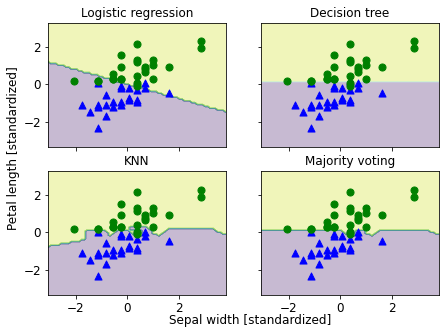

In [58]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue', 
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.7,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.7, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()

아마 예상할 수 있겠지만 앙상블 분류기의 결정 경계는 개별 분류기의 결정 경계를 혼합한 것처럼 보인다. 처음 볼 때는 다수결 투표 결정 경계가 petal width ≥ 0을 기준으로 x축에 수평으로 그어진 결정 트리의 경계와 비슷하게 보인다. 자세히 보면 k-최근접 이웃 분류기의 비선형성이 섞여 있는 것을 알 수 있다.

앙상블을 위해 개별 분류기의 매개변수를 튜닝하기 전에 GridSearchCV 객체 안에 있는 매개변수에 어떻게 접근할 수 있는지 <code>get_params()</code> 메서드를 호출해서 알아보겠다.

In [59]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf',
                  LogisticRegression(C=0.001, random_state=1,
                                     solver='liblinear')]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1, solver='liblinear')]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf_

<code>get_params()</code> 메서드에서 반환되는 값을 살펴보면 개별 분류기의 속성에 접근하는 방법을 알 수 있다. 예시를 보이기 위해 그리드 서치로 로지스틱 회귀 분류기의 규제 매개변수 C와 결정 트리의 깊이를 튜닝해보자.

In [62]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1,
                                                                                               solver='liblinear')]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

그리드 서치 실행이 완료되면 각각의 하이퍼파라미터 조합과 10-겹 교차 검증으로 계산한 평균 ROC AUC 점수를 다음과 같이 출력할 수 있다.

In [83]:
for params, mean_score, scores in zip(grid.cv_results_['params'], 
                                      grid.cv_results_['mean_test_score'],
                                      grid.cv_results_['std_test_score']):
    print("%0.3f+/-%0.2f %r"
          % (mean_score, scores, params))

0.983+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967+/-0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967+/-0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [84]:
print('최적의 매개변수: %s' % grid.best_params_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [85]:
print('정확도: %.2f' % grid.best_score_)

정확도: 0.98


여기서 볼 수 있듯이 규제 강도가 낮을 때(C=100.0) 최상의 교차 검증 결과를 얻었다. 반면 트리 깊이는 성능에 전혀 영향을 주지 않는 것 같다. 이 데이터를 분할하는 데는 깊이가 1인 결정 트리로 충분하다. 테스트 세트를 모델 평가에 한 번 이상 사용해서는 안 된다는 것을 기억하자.

앞서 보았듯이 보팅 분류기의 정확도가 높게 나타났는데, 보팅으로 여러 개의 기반 분류기를 결합한다고 해서 무조건 기반 분류기보다 예측 성능이 향상되지는 않는다. 데이터의 특성과 분포 등 다양한 요건에 따라 오히려 기반 분류기 중 가장 좋은 분류기의 성능이 보팅했을 때보다 나을 수도 있다.

그럼에도 불구하고 지금 소개하는 보팅을 포함해 배깅과 부스팅 등의 앙상블 방법은 전반적으로 다른 단일 ML 알고리즘보다 뛰어난 예측 성능을 가지는 경우가 많다. 고정된 데이터 세트에서 단일 ML 알고리즘이 뛰어난 성능을 발휘하더라도 현실 세계는 다양한 변수와 예측이 어려운 규칙으로 구성돼있다. 다양한 관점을 가진 알고리즘이 서로 결합해 더 나은 성능을 실제 환경에서 끌어낼 수 있다. 약간 동떨어진 이야기일 수 있지만, 현실 세계의 프로젝트에서도 똑똑한 사람들로만 구성된 팀보다는 다양한 경험과 백그라운드를 가진 사람들로 구성된 팀이 오히려 프로젝트를 성공으로 이끌 가능성이 높다. 후자의 경우는 다양한 관점에서 문제에 접근하고 서로의 약점을 보완해서 높은 유연성을 가질 수 있기 때문이다. 높은 유연성은 그동안 경험해 보지 못한 새로운 문제에 대한 해결책을 좀 더 쉽게 제시할 수 있다. 반면에 전자의 경우 우수한 인재들이 자신이 잘 아는 분야에 대해서 고정된 관점을 가지는 경우가 많아 상대적으로 유연성이 떨어질 수 있다.

ML 모델의 성능은 이렇게 다양한 테스트 데이터에 의해 검증되므로 어떻게 높은 유연성을 가지고 현실에 대처할 수 있는가가 중요한 ML 모델의 평가요소가 된다. 이런 관점에서 편향-분산 트레이드오프는 ML 모델이 극복해야 할 중요 과제다. 보팅과 스태킹 등은 서로 다른 알고리즘을 기반으로 하고 있지만, 배깅과 부스팅은 대부분 결정 트리 알고리즘을 기반으로 한다. 결정 트리 알고리즘은 쉽고 직관적인 분류 기준을 가지고 있지만 정확한 예측을 위해 학습 데이터의 예외 상황에 집착한 나머지 오히려 과대적합이 발생해 실제 테스트 데이터에서 예측 성능이 떨어지는 현상이 발생하기 쉽다. 하지만 앙상블 학습에서는 이 같은 결정 트리 알고리즘의 단점을 수십~수천 개의 매우 많은 분류기를 결합해 다양한 상황을 학습하게 함으로써 극복하고 있다. 결정 트리 알고리즘의 장점은 그대로 취하고 단점은 보완하면서 편향-분산 트레이드오프의 효과를 극대화할 수 있다는 것이다.

# 미주

<b id="p01">1</b> 실패할 확률이 25%일 때 11개의 분류기로 구성된 앙상블이 실패하려면 여섯 개 이상이 실패해야 한다. 11개의 분류기에서 실패할 여섯 개를 조합할 수 있는 가짓수는 $\binom{11}{6}$이다. 결국 여섯 개의 분류기가 실패할 확률은 $\binom{11}{6}0.25^6(1-0.25)^{(11-6)}$이 된다. 이런 방식으로 11개가 모두 실패할 경우까지 확률을 더한다. [↩](#a01)

<b id="p02">2</b> 확률 질량 함수의 누적 값은 사이파이 <code>binom.cdf()</code>를 사용하면 간단하게 구할 수 있다. 실패 확률이 25%인 분류기가 여섯 개 이상 실패할 확률을 누적한 것은 성공 확률 75%인 분류기가 다섯 개 이하로 성공할 확률을 누적한 것과 같으므로 다음과 같이 구할 수 있다. <code>from scipy.stats import binom; binom.cdf(5, 11, 0.75)</code> [↩](#a02)

<b id="p03">3</b> 다음 식에서 $i_0$는 클래스 0일 때는 1이고, 그 외에는 0이다. 마찬가지로 $i_1$은 클래스 1일 때 1이고, 그 외에는 0이다. 결국 [0.4, 0.6]에서 가장 큰 값의 인덱스를 찾는 문제가 된다. [↩](#a03)

<b id="p04">4</b><code> bincount()</code> 함수는 0 이상의 정수로 된 배열을 입력받아 각 정수가 등장하는 횟수를 카운트한다. 정수 값에 해당하는 인덱스 위치에 카운트가 저장된 배열이 반환된다. 예를 들어 <code>np.bincount([0, 2, 0])</code>은 [2, 0, 1]이 반환된다. 정수가 아니라 실수가 입력되면 소수점 이하를 버린다. weights 배열이 주어지면 카운트대신 입력 배열과 같은 위치의 weights 값을 더한다. 본문의 예에서처럼 <code>np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])</code>은 [0.4, 0.6] 넘파이 배열이 반환된다. <code>np.argmax()</code>는 배열에서 가장 큰 값을 가진 위치의 인덱스를 반환한다. [↩](#a04)

<b id="p05">5</b> 보정이 잘 되어 있다는 뜻은 <code>predict_proba()</code> 메서드에서 0.7의 확률을 얻은 샘플 중에 실제로 70%가 양성 클래스에 속한다는 의미다. 사이킷런에서는 <code>sklearn.calibration.CalibratedClassifierCV</code> 클래스를 사용하여 보정된 분류기를 훈련시킬 수 있다. [↩](#a05)

<b id="p06">6</b> <code>np.average()</code> 함수에 weights 매개변수가 주어지면 weights 배열의 비율을 더할 원소에 곱해 가중 평균을 구한다. [↩](#a06)

<b id="p07">7</b> 결정 트리는 리프 노드의 클래스별 샘플 비율이 클래스 확률이 된다. 예를 들어 어떤 리프 노드의 클래스별 샘플 개수가 [10, 20, 70]이라면 이 리프 노드에 도달한 샘플의 클래스 확률은 [0.1, 0.2, 0.7]이 된다. k-최근접 이웃 분류기는 주어진 샘플의 최근접 이웃 클래스별 샘플 비율이 클래스 확률이 된다. 예를 들어 k=5인 최근접 이웃 분류기에서 이웃한 샘플의 클래스별 빈도가 [1, 1, 3]이라면 이 샘플의 클래스 확률은 [0.2, 0.2, 0.6]이 된다. [↩](#a07)

<b id="p08">8</b> 로지스틱 회귀는 오즈비에 로그를 취한 형태로 성공 확률 p는 시그모이드 곡선을 그린다. 이 그래프를 확률 질량 함수를 누적하여 나타낸 누적 분포 함수<sup>cumulative distirbution function</sup>로 해석할 수 있다. [↩](#a08)